# MAIN

In [1]:
# ========== 0. MAIN ==========

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import datetime
import random

# Data Loading & Preprocessing

In [ ]:
# ========== 1. Data Loading & Preprocessing ==========

# Update the file paths if the CSV files are in a different directory.
features = pd.read_csv("features-daily_2024-11_dairy.csv", 
                       parse_dates=['daydate', 'currentlastsalesdate', 'currentlastreceiptdate', 'lastsalesdate', 'storeDate'])
labels = pd.read_csv("labels_2024-11_dairy.csv", 
                     parse_dates=['storeDate', 'historyTime', 'outOfShelfTime', 'PlannedAbandonmentDate'])
trxn = pd.read_csv("trxn_2024-11_dairy.csv", 
                   parse_dates=['TransactionDate', 'TransactionTime', 'TransactionInitiatedTimestamp', 
                                'TransactionLineItemScanTimestamp', 'TransactionLineItemScanUTCTimestamp'])

# Remove holiday data (Thanksgiving) based on the assumption that Thanksgiving is on 2024-11-28.
# If you have more holiday dates or a different approach, update this section accordingly.
holiday_date = pd.Timestamp('2024-11-28')
features = features[features['daydate'] != holiday_date]
labels = labels[labels['storeDate'] != holiday_date]
trxn = trxn[trxn['TransactionDate'] != holiday_date]

# Drop duplicates if any
features.drop_duplicates(inplace=True)
labels.drop_duplicates(inplace=True)
trxn.drop_duplicates(inplace=True)

# Phantom Inventory Flagging

In [3]:
# ========== 2. Phantom Inventory Flagging ==========

# Aggregate the transaction data to the daily level per SKU.
# For example, summing total quantity and counting the number of transactions.
trxn_agg = trxn.groupby(['ItemSku', 'TransactionDate']).agg({
    'TotalItemQuantity': 'sum',    # Total quantity sold in transactions
    'TransactionId': 'nunique',    # Number of unique transactions
    'Quantity': 'sum',             # Alternatively, use Quantity if it captures sold units
    'VoidIndicator': 'sum'         # Sum here gives number of voided transactions per day
}).reset_index()

# Rename columns to align with the features dataset
trxn_agg.rename(columns={
    'ItemSku': 'itemsku', 
    'TransactionDate': 'daydate',
    'TotalItemQuantity': 'trxn_total_qty',
    'TransactionId': 'trxn_count',
    'Quantity': 'trxn_quantity',
    'VoidIndicator': 'void_count'
}, inplace=True)

# Merge aggregated transaction data with features based on itemsku and daydate.
features = features.merge(trxn_agg, on=['itemsku', 'daydate'], how='left')
# Fill missing transaction data with 0. # Fill missing values (i.e., days with no transactions) with 0
features['trxn_total_qty'] = features['trxn_total_qty'].fillna(0)
features['trxn_count'] = features['trxn_count'].fillna(0)
features['trxn_quantity'] = features['trxn_quantity'].fillna(0)
features['void_count'] = features['void_count'].fillna(0)

# Merge the features and labels data on product identifier and date.
# Here, we assume the join keys are: 'itemsku' in features and 'ItemSku' in labels,
# and that 'daydate' in features corresponds to 'storeDate' in labels.
merged = pd.merge(
    features, 
    labels, 
    left_on=['itemsku', 'daydate'], 
    right_on=['ItemSku', 'storeDate'], 
    how='left')

# Merge aggregated transaction data with the merged features/labels dataset.
merged = pd.merge(merged, trxn_agg, on=['itemsku', 'daydate'], how='left')

# Rule 1: If the product is flagged as out-of-shelf in labels (i.e. outOfShelf is True) 
# and the reported current balance on hand (DailyBOH) is greater than 0,
# then it may be a phantom inventory.
merged['phantom_flag'] = np.where((merged['outOfShelf'] == True) & (merged['DailyBOH'] > 0), 1, 0)

# Rule 2 (alternative/additional): If, for example, the product is reported as in-stock (PositiveBOHFlag==1),
# but there are no sales (salesQuantity == 0) and there is an out-of-stock count (OOSCount > 0),
# then flag it as phantom.
merged['phantom_flag'] = np.where( (merged['phantom_flag'] == 1) | 
                                   ((merged['PositiveBOHFlag'] == 1) & 
                                    (merged['salesQuantity'] == 0) & 
                                    (merged['OOSCount'] > 0)), 1, 0)

# Features Engineering

In [ ]:
# ========== 3. Features Engineering ==========

# 1. Create a missingness indicator
merged['avg_sales_50to8_missing'] = merged['avg_sales_50to8'].isna().astype(int)

# 2. Create a missingness indicator for 'avg_sales_last7'
merged['avg_sales_last7_missing'] = merged['avg_sales_last7'].isna().astype(int)

# 3. Create an indicator feature for missing CurrentBOH
merged["CurrentBOH_missing"] = merged["CurrentBOH"].isna().astype(int)

# 4. Impute CurrentBOH
#    You can still do forward-fill/backward-fill or a median fill approach
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].ffill()
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].bfill()

# 5.  Create a missing indicator feature that flags which rows originally had missing IMSQuantity.
merged["IMSQuantity_missing"] = merged["IMSQuantity"].isna().astype(int)

# 6. Create a sales gap feature
if "DmdForecastQuantity" in merged.columns and "salesQuantity" in merged.columns:
    merged["sales_gap"] = merged["DmdForecastQuantity"] - merged["salesQuantity"]
else:
    merged["sales_gap"] = np.nan

# 7. Convert day of week to string category if numeric
if "DayofWeek" in merged.columns:
    merged["DayofWeek"] = merged["DayofWeek"].astype(str)

# 8. Forecast Gap Feature: Difference between lead-time and daily demand forecast quantities.
if "LDEFForecastQuantity" in merged.columns and "DmdForecastQuantity" in merged.columns:
    merged["forecast_gap"] = merged["LDEFForecastQuantity"] - merged["DmdForecastQuantity"]
else:
    merged["forecast_gap"] = np.nan

# 9. BOH to MDQ Ratio: Ratio of Current Balance On Hand to Minimum Distribution Quantity.
if "CurrentBOH" in merged.columns and "MDQ" in merged.columns:
    merged["boh_mdq_ratio"] = merged.apply(lambda x: x["CurrentBOH"] / x["MDQ"] if x["MDQ"] != 0 else np.nan, axis=1)
else:
    merged["boh_mdq_ratio"] = np.nan

# 10. Sales to Inventory Ratio: Ratio of sales quantity to DailyBOH (adding 1 to avoid division by zero).
if "salesQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["sales_to_inventory_ratio"] = merged["salesQuantity"] / (merged["DailyBOH"] + 1)
else:
    merged["sales_to_inventory_ratio"] = np.nan

# 11. Weekend Indicator:
#    Create a binary flag if the day of the week is Saturday or Sunday.
#    (Assuming DayofWeek has been converted to string as done earlier.)
merged["is_weekend"] = merged["DayofWeek"].apply(lambda x: 1 if x in ["6", "7"] else 0)

# 12. Ensure date columns are in datetime format
date_cols = ['daydate', 'outOfShelfTime', 'currentlastreceiptdate', 'lastsalesdate']
for col in date_cols:
    if col in merged.columns:
        merged[col] = pd.to_datetime(merged[col], errors='coerce')

# 13. Out-of-Stock Duration
if 'daydate' in merged.columns and 'outOfShelfTime' in merged.columns:
    merged['out_of_stock_duration'] = (merged['daydate'] - merged['outOfShelfTime']).dt.days
    merged['out_of_stock_duration'] = merged['out_of_stock_duration'].fillna(-1)  # -1 for no OOS event
else:
    merged['out_of_stock_duration'] = np.nan

# Prepare data for classification:
# Here we select a subset of numerical features plus categorical features. 
model_data = merged.copy()

feature_columns = ['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'OOSCount',
                   'sales_gap', 'DayofWeek', 'forecast_gap', 'avg_sales_50to8_missing',
                   'avg_sales_last7_missing', 'CurrentBOH_missing', 'IMSQuantity_missing',
                   'boh_mdq_ratio', 'sales_to_inventory_ratio',
                   'is_weekend', 'out_of_stock_duration']
target_column = 'phantom_flag'

# [LightGBM] Model Building: Phantom Inventory Classifier

[LightGBM] [Info] Number of positive: 8667, number of negative: 85125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 93792, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.092407 -> initscore=-2.284598
[LightGBM] [Info] Start training from score -2.284598
[LightGBM] [Info] Number of positive: 8677, number of negative: 87453
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1060
[LightGBM] [Info] Number of data points in the train set: 96130, number of used features: 22
[LightGBM] [Info] [b

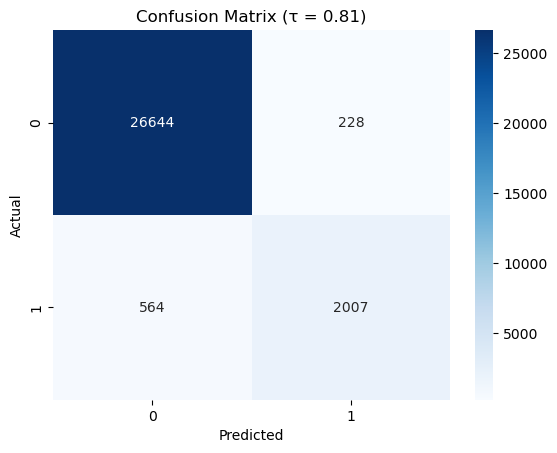

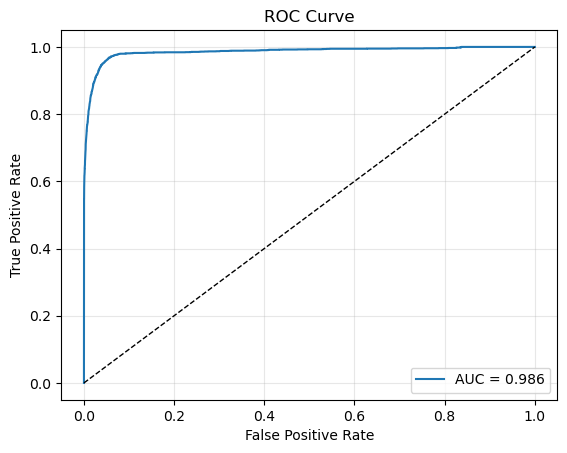

In [ ]:
# ========== 4. [LightGBM] Model Building | Phantom Inventory Classifier ==========

from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
        StratifiedGroupKFold, train_test_split, cross_val_score,
        RandomizedSearchCV)
from sklearn.metrics import (
        precision_recall_curve, f1_score, precision_score,
        recall_score, roc_auc_score)

# ----------------------------------------
# 1.  Train / test split
# ----------------------------------------
X = model_data[feature_columns]
y = model_data[target_column]
groups = model_data['itemsku']

X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
        X, y, groups, test_size=0.2, random_state=42, stratify=y)

# ----------------------------------------
# 2.  Pre‑processing
# ----------------------------------------
cat_cols = ['DayofWeek']
num_cols = [c for c in X_train.columns if c not in cat_cols]

pre = ColumnTransformer([
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# ----------------------------------------
# 3.  LightGBM base model
# ----------------------------------------
lgbm = LGBMClassifier(
        objective='binary',
        n_estimators=300,            # 2000 for the deployment
        learning_rate=0.15,          # 0.05 for the deployment
        num_leaves=64,
        max_depth=-1,
        min_child_samples=30,
        subsample=0.8,
        colsample_bytree=0.6,
        scale_pos_weight=4,          # imbalance handle (tune)
        random_state=42,
        n_jobs=-1)

pipe_lgb = Pipeline([
        ('prep', pre),
        ('lgb',  lgbm)
])

# ----------------------------------------
# 4.  Cross‑validation (no leakage)
# ----------------------------------------
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
auc = cross_val_score(pipe_lgb, X_train, y_train,
                      groups=g_train, cv=cv,
                      scoring='roc_auc', n_jobs=-1)
print(f'CV ROC‑AUC mean ± std: {auc.mean():.3f} ± {auc.std():.3f}')

# ----------------------------------------
# 5.  Light hyper‑parameter search (15 iter, ~5‑10 min)
#     Feel free to increase n_iter if you have time.
# ----------------------------------------
param_dist = {
    'lgb__num_leaves'       : np.arange(32, 97, 16),
    'lgb__min_child_samples': [10, 20, 30, 40],
    'lgb__subsample'        : [0.7, 0.8, 0.9],
    'lgb__colsample_bytree' : [0.5, 0.6, 0.7],
    'lgb__scale_pos_weight' : [3, 4, 5]
}

search = RandomizedSearchCV(
        pipe_lgb, param_dist,
        n_iter=10, cv=cv, n_jobs=-1,
        scoring='roc_auc', random_state=42, verbose=1)

search.fit(X_train, y_train, groups=g_train)
best_model = search.best_estimator_
print('Best CV ROC‑AUC:', search.best_score_)

# ----------------------------------------
# 6.  Pick threshold for Precision ≥ 0.90
# ----------------------------------------
from sklearn.metrics import confusion_matrix

def eval_with_precision_floor(model,
                              X_ref, y_ref,
                              X_test, y_test,
                              floor=0.93, verbose=True):
    """
    Choose the *smallest* threshold that reaches 'floor' precision on X_ref/y_ref,
    then evaluate on X_test/y_test.

    Returns (threshold, metrics_dict)
    """
    # ---------- 1) choose threshold on reference set ----------
    p_ref = model.predict_proba(X_ref)[:, 1]
    prec, rec, thr = precision_recall_curve(y_ref, p_ref)

    # thr has length = len(prec) - 1.  We want the first τ s.t. P(τ) ≥ floor
    idx = np.where(prec[:-1] >= floor)[0]
    if len(idx) == 0:
        raise ValueError(f"Model never reaches precision {floor:.2f}")
    tau = thr[idx[0]]

    # ---------- 2) evaluate on test set ----------
    p_test = model.predict_proba(X_test)[:, 1]
    y_hat  = (p_test >= tau).astype(int)

    metrics = {
        "precision": precision_score(y_test, y_hat),
        "recall"   : recall_score(y_test, y_hat),
        "f1"       : f1_score(y_test, y_hat),
        "roc_auc"  : roc_auc_score(y_test, p_test),
        "threshold": tau,
        "cm"       : confusion_matrix(y_test, y_hat)
    }
    if verbose:
        print(f"Threshold @P≥{floor:.2f} (chosen on ref): {tau:.2f}")
        print("Test metrics:", {k: round(v, 3) if k!='cm' else v
                               for k, v in metrics.items()
                               if k!='threshold'})
    return tau, metrics

tau, metrics = eval_with_precision_floor(best_model,
                                         X_ref=X_train, y_ref=y_train,   # or a held‑out 10 % slice
                                         X_test=X_test, y_test=y_test,
                                         floor=0.93)

# ----------------------------------------
# 7.  Final test‑set evaluation
# ----------------------------------------
proba_test = best_model.predict_proba(X_test)[:, 1]
y_pred = (proba_test >= tau).astype(int)

print('Test Precision:', precision_score(y_test, y_pred))
print('Test Recall   :', recall_score(y_test, y_pred))
print('Test F1       :', f1_score(y_test, y_pred))
print('Test ROC‑AUC  :', roc_auc_score(y_test, proba_test))

# ----------------------------------------
# 8.  Plotting
# ----------------------------------------
threshold = 0.81       # Precision ≥ 0.90 the cut‑off
y_proba   = best_model.predict_proba(X_test)[:, 1]
y_pred    = (y_proba >= threshold).astype(int)

# 1) Confusion Matrix
from sklearn.metrics import confusion_matrix, roc_curve, auc

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (τ = {:.2f})'.format(threshold))
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

# 2) ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(roc_auc))
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Model Evaluation

[LightGBM] [Info] Number of positive: 8667, number of negative: 85125
[LightGBM] [Info] Number of positive: 8677, number of negative: 87453
[LightGBM] [Info] Number of positive: 7339, number of negative: 83821
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 93792, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.092407 -> initscore=-2.284598
[LightGBM] [Info] Start training from score -2.284598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

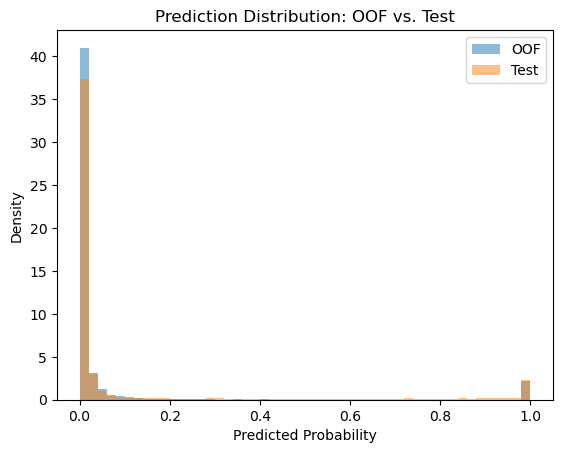

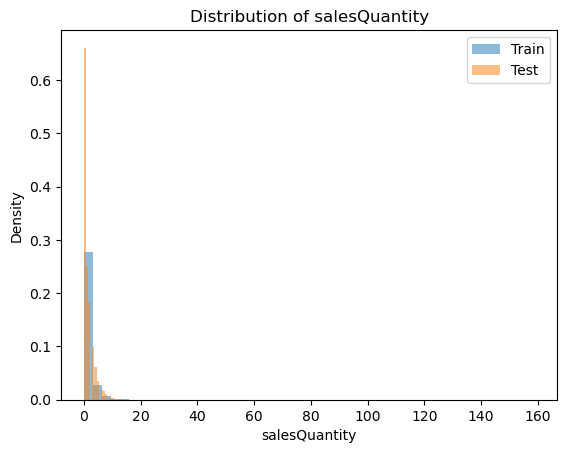

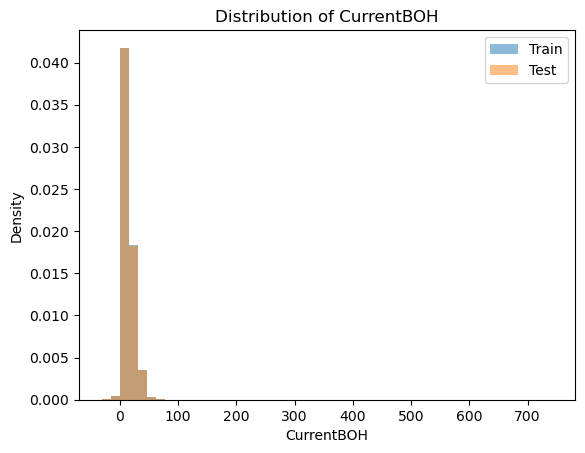

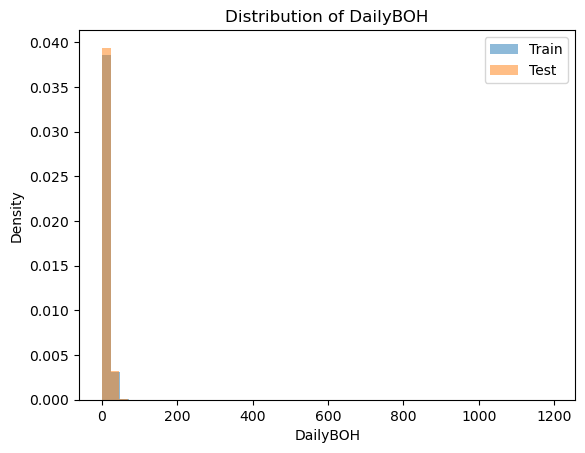

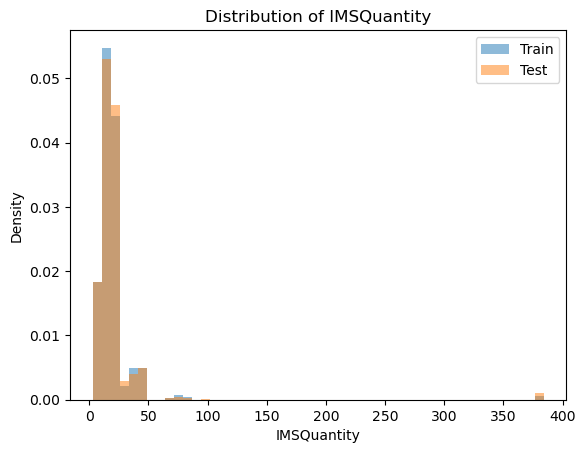

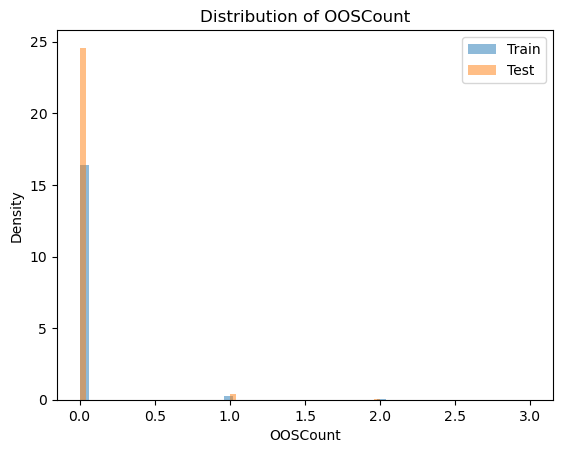

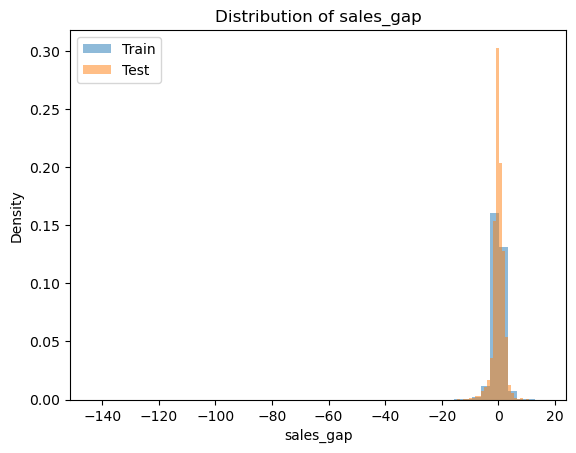

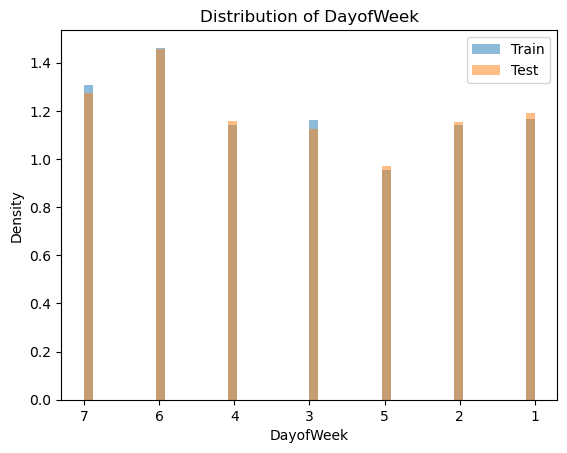

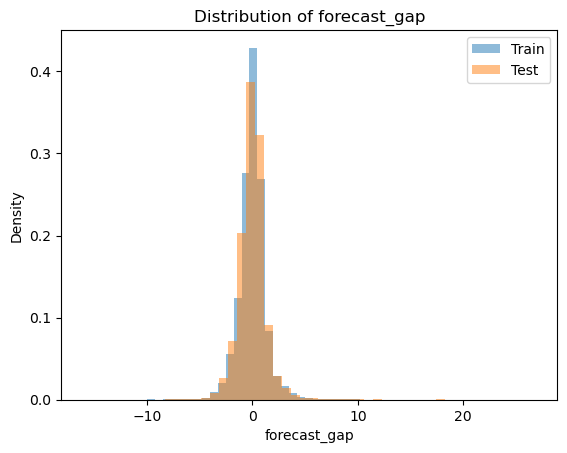

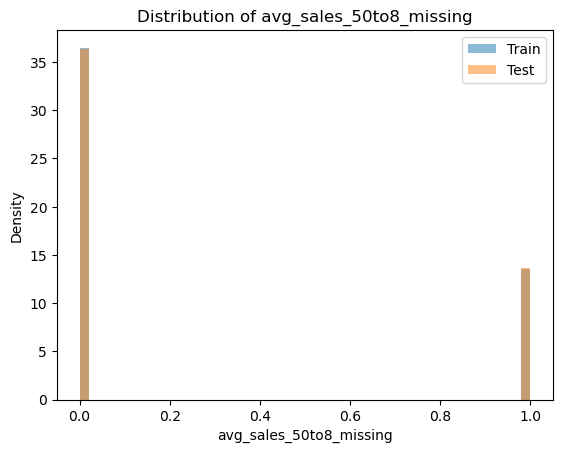

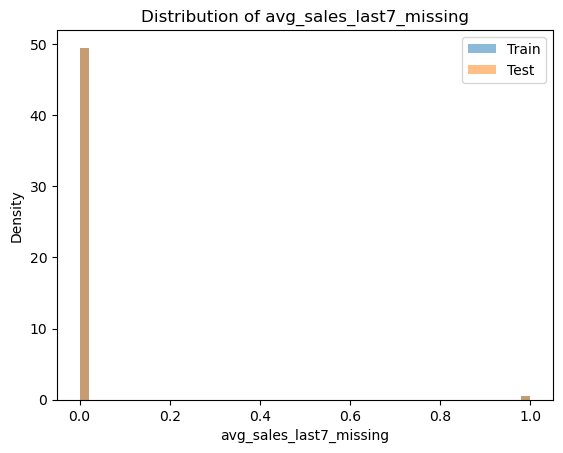

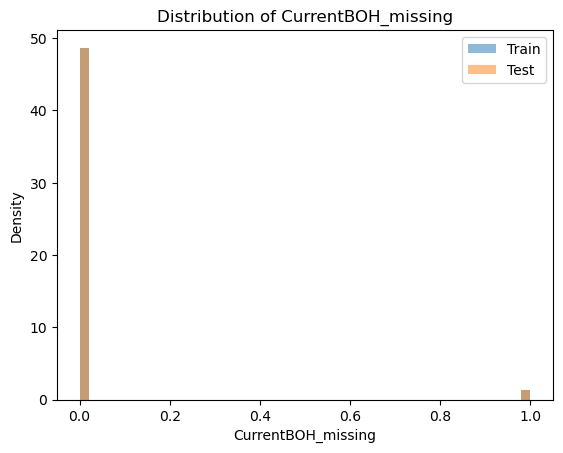

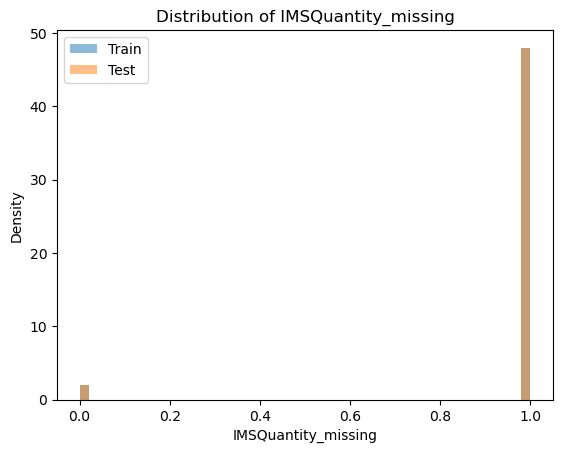

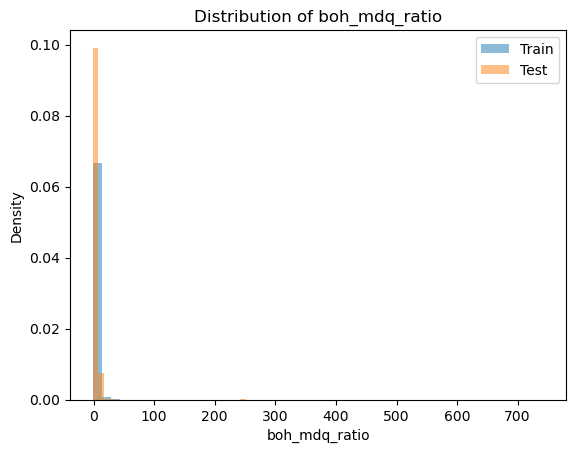

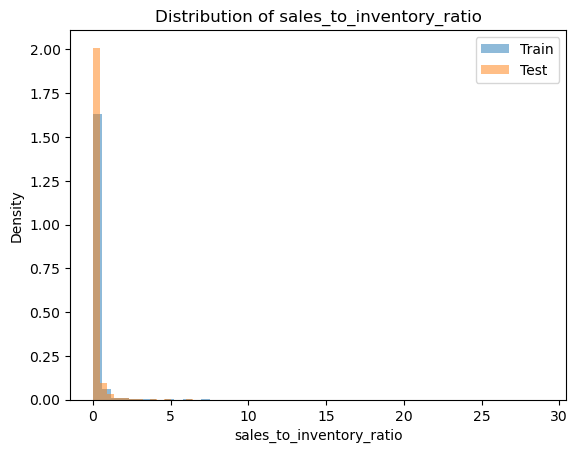

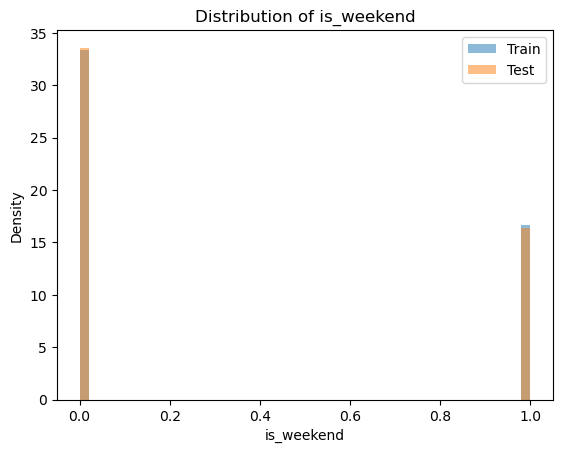

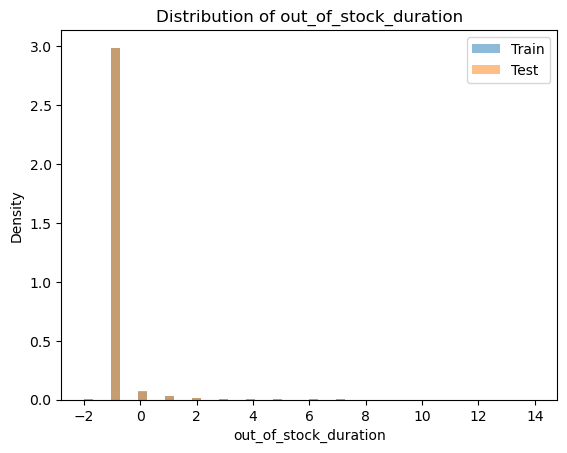

[LightGBM] [Info] Number of positive: 8226, number of negative: 85990
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 94216, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087310 -> initscore=-2.346931
[LightGBM] [Info] Start training from score -2.346931
New Hold‑Out AUC: 0.9836959655674292
LightGBM complexity parameters:
  n_estimators      : 300
  learning_rate     : 0.15
  num_leaves        : 64
  max_depth         : -1
  min_child_samples : 10
  subsample         : 0.9
  colsample_bytree  : 0.7
  scale_pos_weight  : 4


In [6]:
# ========== 5. [LightGBM] Model Evaluation I: OOF & Each Feature ==========

# ─── Insert this after RandomizedSearchCV & final proba_test ───

from sklearn.model_selection import cross_val_predict

# 1) Generate OOF predictions on the training fold
oof_preds = cross_val_predict(
    best_model,              # Tuned Pipeline
    X_train, y_train,
    groups=g_train,
    cv=cv,
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# 2) Grab the test‐set probabilities (you already computed this)
test_preds = proba_test      # shape = (n_test_samples,)

# 3) Build simple DataFrames for distribution checks
train_df = X_train.copy()
train_df[target_column] = y_train.values

test_df  = X_test.copy()
test_df[target_column] = y_test.values

# 4) List of features to loop over
features = feature_columns    # as you defined at the top

# ─── Evaluation 1: Compare OOF vs. Test Prediction Distributions ───
# Quick sanity‐check prints
print("OOF preds shape:", oof_preds.shape)
print("Test preds shape:", test_preds.shape)
print("train_df columns:", train_df.columns.tolist()[:5], "…")
print("test_df columns :", test_df.columns.tolist()[:5], "…")
print("Number of features:", len(features))

import matplotlib.pyplot as plt

plt.hist(oof_preds, bins=50, density=True, alpha=0.5, label='OOF')
plt.hist(test_preds, bins=50, density=True, alpha=0.5, label='Test')
plt.legend()
plt.title('Prediction Distribution: OOF vs. Test')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.show()

# ─── Evaluation 2: Check Feature Distribution Drift ───
# train_df / test_df: DataFrames containing the same feature columns
# features: a list of column names you want to inspect
for feat in features:
    plt.figure()
    plt.hist(train_df[feat], bins=50, density=True, alpha=0.5, label='Train')
    plt.hist(test_df[feat],  bins=50, density=True, alpha=0.5, label='Test')
    plt.legend()
    plt.title(f'Distribution of {feat}')
    plt.xlabel(feat)
    plt.ylabel('Density')
    plt.show()

# ─── Evaluation 3: Sanity‑Check with a New Hold‑Out Split ───
from sklearn.model_selection import train_test_split
from sklearn.metrics         import roc_auc_score
from sklearn.base            import clone

# Carve out a new hold‑out set from the original training data
X_subtrain, X_holdout, y_subtrain, y_holdout = train_test_split(
    X_train, y_train,
    test_size=0.20,
    random_state=123,
    stratify=y_train
)

# Clone the tuned pipeline and retrain on the sub‑training set
model_temp = clone(best_model)
model_temp.fit(X_subtrain, y_subtrain)

# Evaluate on the new hold‑out set
y_holdout_proba = model_temp.predict_proba(X_holdout)[:, 1]
print('New Hold‑Out AUC:', roc_auc_score(y_holdout, y_holdout_proba))

# ─── Evaluation 4: Inspect / Monitor Model Complexity ───
# Extract LightGBM parameters from the best pipeline
lgb_params = best_model.named_steps['lgb'].get_params()

print("LightGBM complexity parameters:")
print(f"  n_estimators      : {lgb_params['n_estimators']}")
print(f"  learning_rate     : {lgb_params['learning_rate']}")
print(f"  num_leaves        : {lgb_params['num_leaves']}")
print(f"  max_depth         : {lgb_params['max_depth']}")
print(f"  min_child_samples : {lgb_params['min_child_samples']}")
print(f"  subsample         : {lgb_params['subsample']}")
print(f"  colsample_bytree  : {lgb_params['colsample_bytree']}")
print(f"  scale_pos_weight  : {lgb_params['scale_pos_weight']}")

# SHAP Explanation

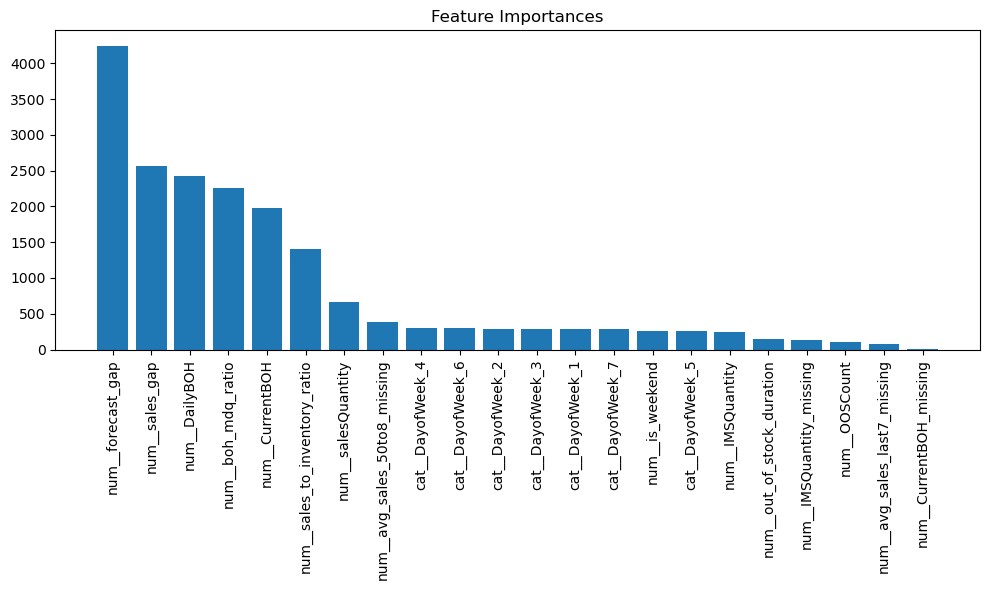

/opt/anaconda3/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


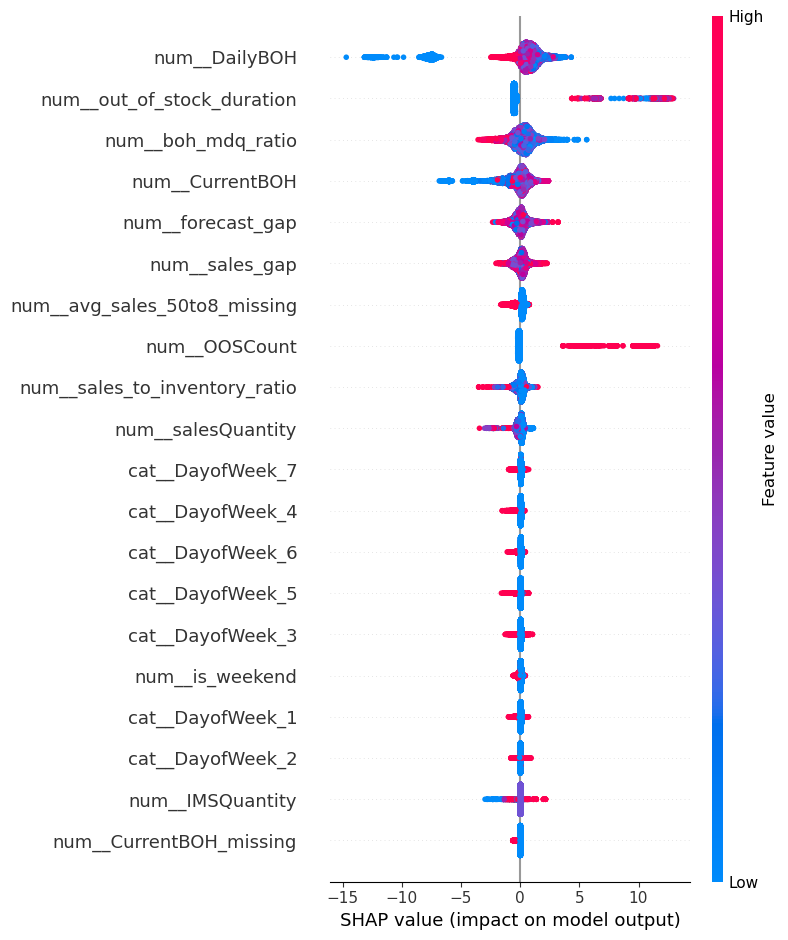

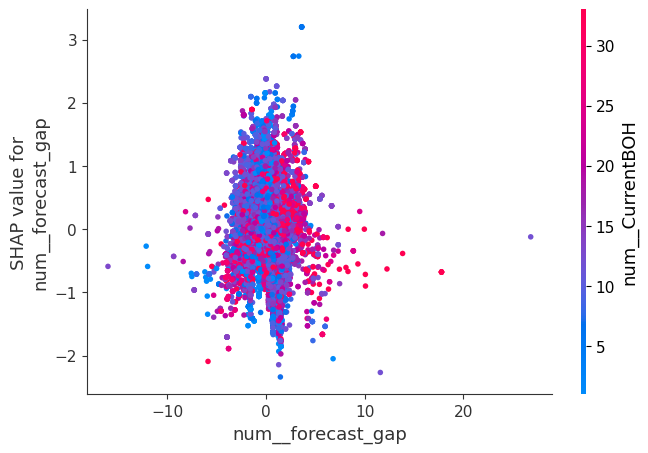

In [7]:
# ========== 6. [LightGBM] Model Evaluation II: Feature Importance & SHAP Explanations ==========

# Plot the model feature importances for a fast, global overview.
# Compute and visualize SHAP values for more accurate, trustworthy feature impact insights.
import shap

# 1) Point these at the trained pipelines & data:
pipeline   = best_model            # e.g. best_lgb_pipeline, best_rf_pipeline, best_xgb_pipeline, lstm_pipeline
X_train    = X_train               # original training DataFrame
X_test     = X_test                # original test     DataFrame
preproc    = pipeline.named_steps['prep']
model      = pipeline.named_steps[list(pipeline.named_steps.keys())[-1]]

# 2) Transform & grab feature names
X_test_trans = preproc.transform(X_test)
feat_names   = preproc.get_feature_names_out()  

# 3) If the model has .feature_importances_, plot them:
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    idx_sorted  = np.argsort(importances)[::-1]

    plt.figure(figsize=(10,6))
    plt.bar(range(len(importances)), importances[idx_sorted])
    plt.xticks(range(len(importances)), feat_names[idx_sorted], rotation=90)
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

    # 4) SHAP with TreeExplainer
    explainer  = shap.TreeExplainer(model)
    # for binary classification, shap_values is a list [neg, pos]
    shap_vals  = explainer.shap_values(X_test_trans)

    # Unify into a 2D array:
    if isinstance(shap_vals, list):
        # TreeExplainer on a binary classifier returns [neg, pos]
        shap_mat = shap_vals[1]
    else:
        # KernelExplainer (or single-output) returns a 2d array directly
        shap_mat = shap_vals

    # Summary plot (samples × features)
    shap.summary_plot(shap_mat,
                    X_test_trans,
                    feature_names=feat_names,
                    show=False)    # you can drop show=False if you prefer

    # Dependence plot on the top feature
    top_feat = feat_names[np.argsort(model.feature_importances_)[::-1][0]]
    shap.dependence_plot(top_feat,
                        shap_mat,
                        X_test_trans,
                        feature_names=feat_names,
                        show=False)

# 5) Otherwise (e.g. the LSTM pipeline without built‐in importances), use KernelExplainer:
else:
    # wrap the pipeline's predict_proba
    f = lambda X: pipeline.predict_proba(X)
    # pick ~100 background samples
    bg = shap.sample(preproc.transform(X_train), 100, random_state=42)
    explainer   = shap.KernelExplainer(f, bg)
    # sample e.g. 100 rows from test for speed
    test_samp   = shap.sample(X_test, 100, random_state=42)
    X_samp_trans= preproc.transform(test_samp)
    shap_vals   = explainer.shap_values(X_samp_trans)

    shap.summary_plot(shap_vals[1], X_samp_trans, feature_names=feat_names)

# Model Deployment

In [ ]:
# ========== 7. [LightGBM] Model Deployment ==========

# -- 1: save the trained pipeline --
import joblib
joblib.dump(best_model, '.../phantom-inventory-model/lgb/model/phantom_lgbm_pipeline.pkl')

# -- 2: save the threshold --
import json, os
os.makedirs('model', exist_ok=True)
with open('.../phantom-inventory-model/lgb/model/threshold.json', 'w') as f:
    json.dump({"precision_floor_threshold": 0.81}, f)